In [1]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval

import networkx as nx


In [2]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]

color_4st=['green','red','blue','black']

In [3]:
def matrixplot(data,title):
	plt.figure()
	plt.imshow(data,vmin =-0.3,vmax = 0.3, cmap = 'jet')
	plt.colorbar()
	plt.title(title)
	plt.xticks(range(32),labels = labels,rotation = 'vertical')
	plt.yticks(range(32),labels = labels,rotation = 'horizontal')

In [4]:
# load chan locs for topoplots
dict_loc=loadmat('chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

FileNotFoundError: [Errno 2] No such file or directory: 'chan_locs/xyzlabels.mat'

In [5]:
# variable names for plotting
states4names=['Independent','Leading','Following','Mutual']
syn2names=['Synch','Synco']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [6]:
indices=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = indices['syn2_condi4_ind']
indices.keys()

dict_keys(['L_lead_ind', 'L_lead_synch_ind', 'L_lead_synco_ind', 'Mutual_ind', 'Mutual_synch_ind', 'Mutual_synco_ind', 'R_lead_ind', 'R_lead_synch_ind', 'R_lead_synco_ind', 'Uncoupled_ind', 'Uncoupled_synch_ind', 'Uncoupled_synco_ind', 'condi4_ind', 'syn2_condi4_ind', 'syn_ind', 'synch_condi4_ind', 'synch_ind', 'synco_condi4_ind', 'synco_ind'])

In [146]:
corrdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = corrdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = corrdict['eeg_partial_correlation144x2']       
intervals144                    = corrdict['intervals144']                       
samples144                      = corrdict['samples144']                         
session144                      = corrdict['session144']                         

In [147]:

#organize the correlation matrices

R_follow_synco = np.zeros((36,7,32,32))
R_lead_synco = np.zeros((36,7,32,32))
R_ind_synco = np.zeros((36,7,32,32))
R_mutual_synco = np.zeros((36,7,32,32))
R_follow_synch = np.zeros((36,7,32,32))
R_lead_synch = np.zeros((36,7,32,32))
R_ind_synch = np.zeros((36,7,32,32))
R_mutual_synch = np.zeros((36,7,32,32))

R_follow_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
R_follow_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
R_lead_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
R_lead_synco[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
R_mutual_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
R_mutual_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
R_ind_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
R_ind_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

R_follow_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
R_follow_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
R_lead_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
R_lead_synch[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
R_mutual_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
R_mutual_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
R_ind_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
R_ind_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]


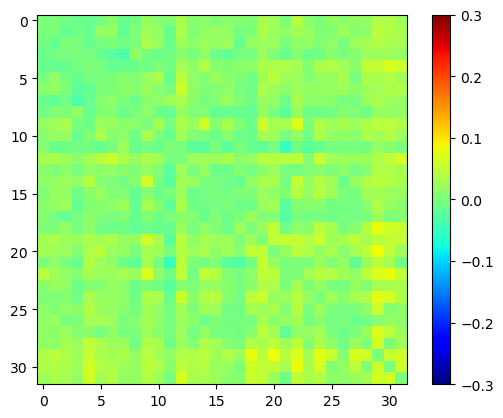

In [148]:
x = np.mean(R_mutual_synco- R_lead_synco,axis = 0)
plt.imshow(x[5,:,:],cmap = 'jet',vmin = -0.3, vmax = 0.3)
plt.colorbar()


In [149]:
#organize the adjacency matrices from partial correlation
eeg_partial_correlation144x2 = eeg_partial_correlation144x2.astype(bool)
A_follow_synco = np.zeros((36,7,32,32))
A_lead_synco = np.zeros((36,7,32,32))
A_ind_synco = np.zeros((36,7,32,32))
A_mutual_synco = np.zeros((36,7,32,32))
A_follow_synch = np.zeros((36,7,32,32))
A_lead_synch = np.zeros((36,7,32,32))
A_ind_synch = np.zeros((36,7,32,32))
A_mutual_synch = np.zeros((36,7,32,32))

A_follow_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
A_follow_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
A_lead_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
A_lead_synco[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
A_mutual_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
A_mutual_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
A_ind_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
A_ind_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

A_follow_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
A_follow_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
A_lead_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
A_lead_synch[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
A_mutual_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
A_mutual_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
A_ind_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
A_ind_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]



In [163]:
f = 1

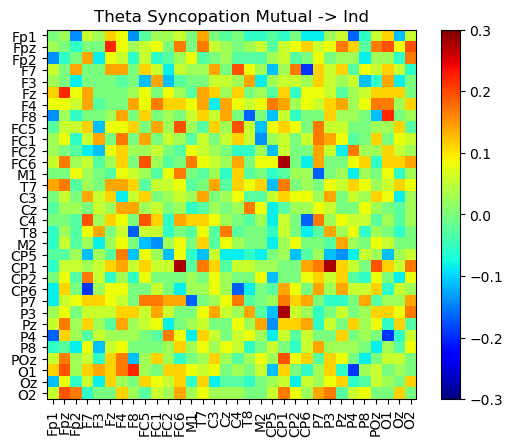

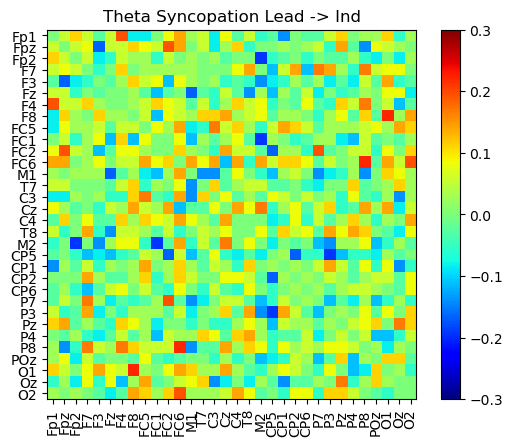

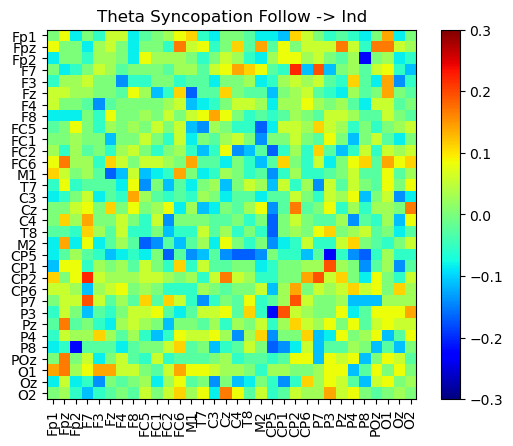

In [164]:
data = np.mean(A_mutual_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Syncopation Mutual -> Ind'
matrixplot(data,title)
data = np.mean(A_lead_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Syncopation Lead -> Ind'
matrixplot(data,title)

data = np.mean(A_follow_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Syncopation Follow -> Ind'
matrixplot(data,title)

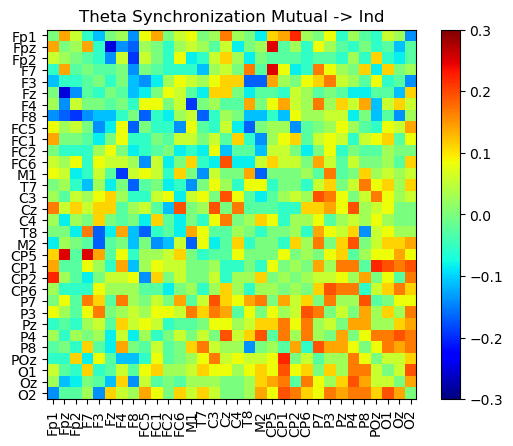

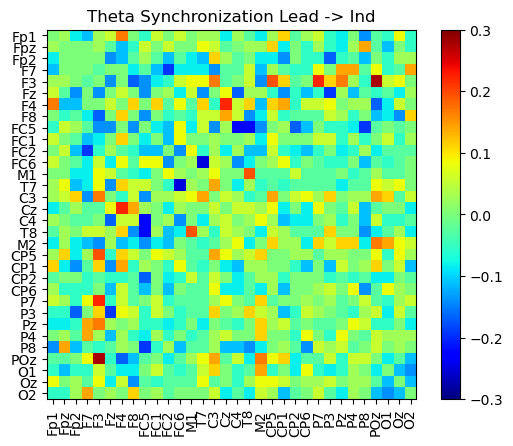

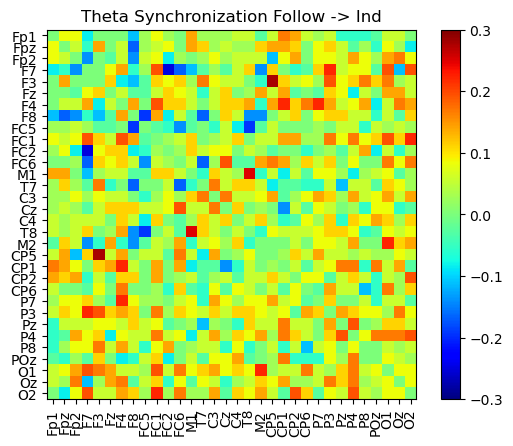

In [194]:
data = np.mean(A_mutual_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Synchronization Mutual -> Ind'
matrixplot(data,title)
data = np.mean(A_lead_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Synchronization Lead -> Ind'
matrixplot(data,title)

data = np.mean(A_follow_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Synchronization Follow -> Ind'
matrixplot(data,title)

In [170]:
G_lead_synco = dict()
G_follow_synco = dict()
G_ind_synco = dict()
G_mutual_synco = dict()

c_lead_synco = np.zeros((36,32))
c_follow_synco = np.zeros((36,32))
c_ind_synco = np.zeros((36,32))
c_mutual_synco = np.zeros((36,32))

G_lead_synch = dict()
G_follow_synch = dict()
G_ind_synch = dict()
G_mutual_synch = dict()

c_lead_synch = np.zeros((36,32))
c_follow_synch = np.zeros((36,32))
c_ind_synch = np.zeros((36,32))
c_mutual_synch = np.zeros((36,32))

for j in range(36):
	G_lead_synco[j] = nx.from_numpy_array(A_lead_synco[j,f,:,:])
	x = nx.clustering(G_lead_synco[j])
	G_follow_synco[j] = nx.from_numpy_array(A_follow_synco[j,f,:,:])
	y = nx.clustering(G_follow_synco[j])
	G_ind_synco[j] = nx.from_numpy_array(A_ind_synco[j,f,:,:])
	z = nx.clustering(G_ind_synco[j])
	G_mutual_synco[j] = nx.from_numpy_array(A_mutual_synco[j,f,:,:])
	w = nx.clustering(G_mutual_synco[j])
	
	for k in range(32):
		c_lead_synco[j,k] = x[k]
		c_follow_synco[j,k] = y[k]
		c_ind_synco[j,k] = z[k]
		c_mutual_synco[j,k] = w[k]
#dc_ind = (dc_lead+dc_ind)/2


for j in range(36):
	G_lead_synch[j] = nx.from_numpy_array(A_lead_synch[j,f,:,:])
	x = nx.clustering(G_lead_synch[j])
	G_follow_synch[j] = nx.from_numpy_array(A_follow_synch[j,f,:,:])
	y = nx.clustering(G_follow_synch[j])
	G_ind_synch[j] = nx.from_numpy_array(A_ind_synch[j,f,:,:])
	z = nx.clustering(G_ind_synch[j])
	G_mutual_synch[j] = nx.from_numpy_array(A_mutual_synch[j,f,:,:])
	w = nx.clustering(G_mutual_synch[j])
	
	for k in range(32):
		c_lead_synch[j,k] = x[k]
		c_follow_synch[j,k] = y[k]
		c_ind_synch[j,k] = z[k]
		c_mutual_synch[j,k] = w[k]
#dc_ind = (dc_lead+dc_ind)/2





Text(0, 0.5, 'clustering coefficient')

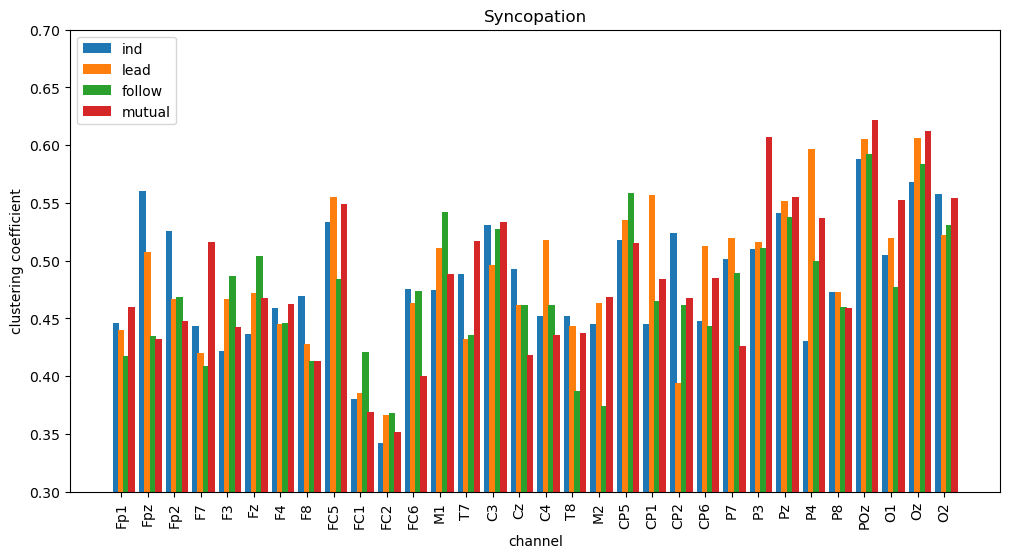

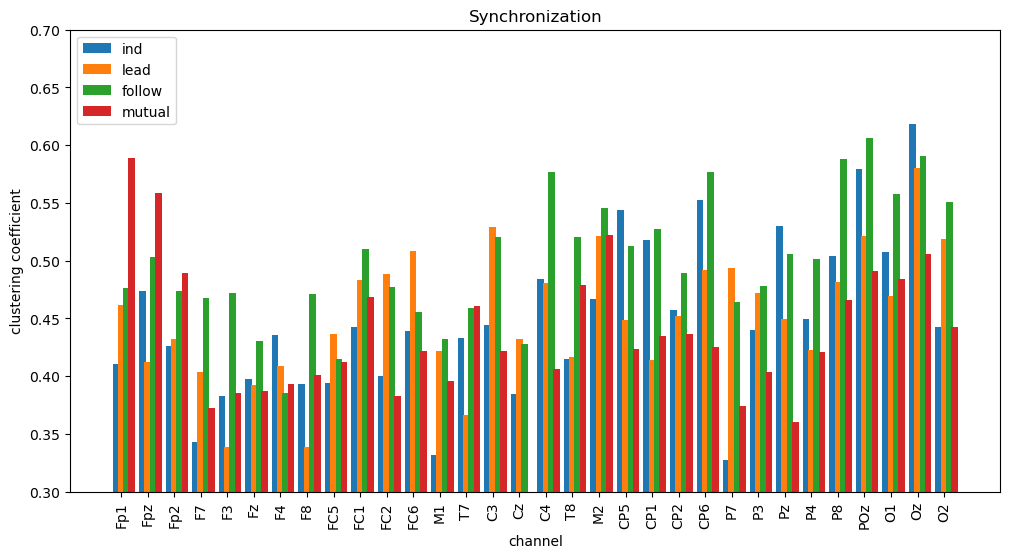

In [195]:
c_synco = [np.mean(c_ind_synco,axis = 0), np.mean(c_lead_synco,axis = 0),np.mean(c_follow_synco,axis = 0),np.mean(c_mutual_synco,axis = 0)]
c_synch = [np.mean(c_ind_synch,axis = 0), np.mean(c_lead_synch,axis = 0),np.mean(c_follow_synch,axis = 0),np.mean(c_mutual_synch,axis = 0)]
plt.figure(figsize = (12,6))
plt.bar(np.arange(32),c_synco[0],width = 0.25)
plt.bar(np.arange(32)+0.2,c_synco[1],width = 0.25)
plt.bar(np.arange(32)+0.4,c_synco[2],width = 0.25)
plt.bar(np.arange(32)+0.6,c_synco[3],width = 0.25)
plt.xticks(np.arange(32)+0.2,labels = labels,rotation = 'vertical')
plt.legend(('ind','lead','follow','mutual'), loc = 'upper left')
plt.title('Syncopation')
plt.xlabel('channel')
plt.ylabel('clustering coefficient')
plt.ylim((0.3,0.7))

plt.figure(figsize = (12,6))
plt.bar(np.arange(32),c_synch[0],width = 0.25)
plt.bar(np.arange(32)+0.2,c_synch[1],width = 0.25)
plt.bar(np.arange(32)+0.4,c_synch[2],width = 0.25)
plt.bar(np.arange(32)+0.6,c_synch[3],width = 0.25)
plt.xticks(np.arange(32)+0.2,labels = labels,rotation = 'vertical')
plt.legend(('ind','lead','follow','mutual'),loc = 'upper left')
plt.title('Synchronization')
plt.xlabel('channel')
plt.ylabel('clustering coefficient')
plt.ylim((0.3,0.7))
# plt.figure()
# plt.bar(range(32),c_synch)
# plt.xticks(range(32),labels = labels,rotation = 'vertical')
# plt.legend(('lead','follow','mutual','ind'))
# plt.title('Synchronization')
# plt.xlabel('channel')
plt.ylabel('clustering coefficient')